# THE BATTLE OF NEIGHBORHOODS

## Introduction:

New York City's demographics show that it is a large and ethnically diverse metropolis. With it's diverse culture , comes diverse food items. There are many resturants in New york City, each beloning to different categories like Chinese , Indian , French, Turkish etc.

So as part of this project , we will list and visualize all major parts of New York City that has great Chinese restaurants.

## Data:

For this project we need the following data:

New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
Chinese restaurants in each neighborhood of new york city.
GeoSpace data

### Questions that will be answers at the end of this project :
1. What are best location in New York City for Chinese Cuisine?
2. Which areas have potential Chinese Restaurant Market?
3. Which all areas lack Chinese Restaurants?
4. Which is the best place to stay if you prefer Chinese Cuisine?

## Methodology:
1. We begin by collecting the New York city data from "https://cocl.us/new_york_dataset".
2. We will find all venues for each neighborhood using FourSquare API.
3. We will then filter out all Chinese Restuarant venues.
4. Next using FourSquare API, we will find the Ratings, Tips, and Like count for all the Chinese Resturants.
5. Next we will sort the data keeping Ratings as the constraint.
6. Finally, we will visualize the Ranking of neighborhoods using python's Folium library.


In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup

#!pip install geocoder
import geocoder
import os

#!pip install folium
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline




In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [3]:

def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'GQIW355LYKLDK4YAUZ4F51QOW3W3BJA23IE0SFTFNSY1ZSPC' # your Foursquare ID
    CLIENT_SECRET = 'ZXM3TB24VHVETT4LPLTTBTUNWQSKOUI1N0ECRTZWXASUVP40' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
  
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [22]:
def get_venue_details(venue_id):
    CLIENT_ID = 'XKKHOJHD5WJRUABPVE4BHXGPJC0L2H5XIJ0EKLZOL4QQNBS0' # your Foursquare ID
    CLIENT_SECRET = 'ET4Y2WKDD5CV5QBVQY3SWLYDNMCCEJ4YOSWWATVK1SQXNM00' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [5]:
url='https://cocl.us/new_york_dataset'
resp=requests.get(url).json()
# all data is present in features label
features=resp['features']
    
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
# instantiate the dataframe
new_york_data = pd.DataFrame(columns=column_names)
    
for data in features:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)


In [6]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
new_york_data.shape

(306, 4)

Now let create a BAR PLOT to show different Neighborhoods in New York.

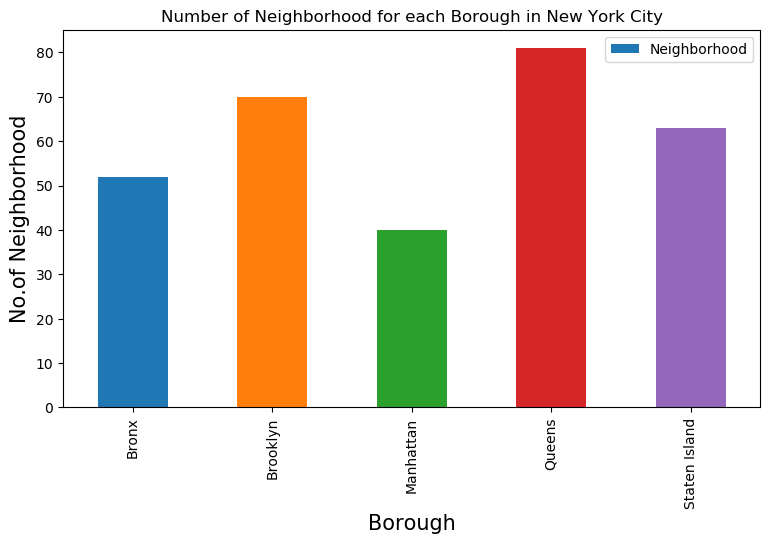

In [8]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

From the above Bar Plot, we can see that Queens has highest number of neighborhoods.


Next we will collect Chinese restaurants for each Neighborhood.

In [10]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_restaurants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Chinese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(chinese_restaurants)))
    for restaurant_detail in chinese_restaurants.values.tolist():
        id, name , category=restaurant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Chinese Restaurants in Wakefield, Bronx:3
( 2 / 306 ) Chinese Restaurants in Co-op City, Bronx:3
( 3 / 306 ) Chinese Restaurants in Eastchester, Bronx:1
( 4 / 306 ) Chinese Restaurants in Fieldston, Bronx:0
( 5 / 306 ) Chinese Restaurants in Riverdale, Bronx:0
( 6 / 306 ) Chinese Restaurants in Kingsbridge, Bronx:0
( 7 / 306 ) Chinese Restaurants in Marble Hill, Manhattan:1
( 8 / 306 ) Chinese Restaurants in Woodlawn, Bronx:0
( 9 / 306 ) Chinese Restaurants in Norwood, Bronx:4
( 10 / 306 ) Chinese Restaurants in Williamsbridge, Bronx:1
( 11 / 306 ) Chinese Restaurants in Baychester, Bronx:4
( 12 / 306 ) Chinese Restaurants in Pelham Parkway, Bronx:4
( 13 / 306 ) Chinese Restaurants in City Island, Bronx:1
( 14 / 306 ) Chinese Restaurants in Bedford Park, Bronx:3
( 15 / 306 ) Chinese Restaurants in University Heights, Bronx:0
( 16 / 306 ) Chinese Restaurants in Morris Heights, Bronx:2
( 17 / 306 ) Chinese Restaurants in Fordham, Bronx:1
( 18 / 306 ) Chinese Restaurants in Ea

Now that we have got all the chinese restaurants in new york city , we will analyze it.

In [11]:
chinese_rest_ny.head() 

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4edbac4e775bcc53fc0ed5f8,Hong Kong China King
1,Bronx,Wakefield,4c3de66616ca95215b17bc7f,Dragon Star Chinese Food
2,Bronx,Wakefield,4e2710b7a809510950dd6b32,Double Dragon
3,Bronx,Co-op City,4c9d5f2654c8a1cd2e71834b,Guang Hui Chinese Restaurant
4,Bronx,Co-op City,4e4df7abbd4101d0d79f476b,China Top


In [12]:
chinese_rest_ny.shape

(409, 4)

### From the above result, we see that there are 409 Chinese Restaurants across New York City.
Now let create a BAR PLOT to show Number of Chinese Restaurants for each Borough in New York City.

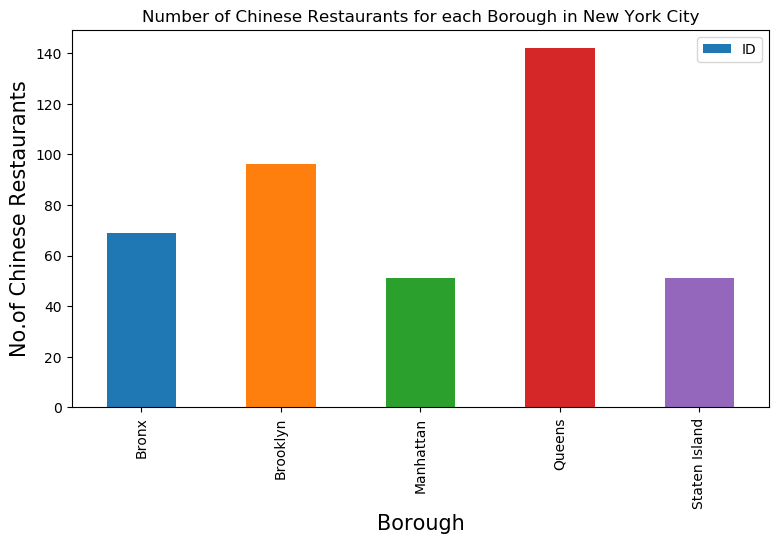

In [27]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Restaurants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Restaurants', fontsize=15)
#giving a bar plot
chinese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

#### From the above Bar Plot, we can see that Queens has highest number of Chinese restaurants

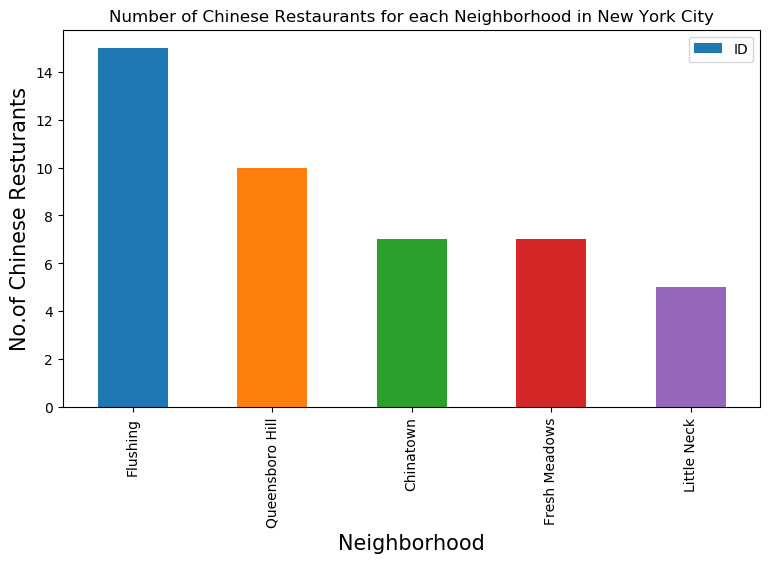

In [28]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Restaurants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Resturants', fontsize=15)
#giving a bar plot
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [29]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Flushing']

,Borough,Neighborhood,ID,Name
189,Queens,Flushing,5747a89b498ee4b7a5106556,DunHuang Lanzhou Beef Noodle
190,Queens,Flushing,52235ea211d2fe55782d764c,Dong Yi Feng
191,Queens,Flushing,4fa3f81be4b0a34ac673bf1e,Taipei Hong 台北夯
192,Queens,Flushing,4abfef82f964a520179320e3,New Imperial Palace 東湖
193,Queens,Flushing,4ef37491d3e32dc398c7c5c7,Laoma Mala Tang
194,Queens,Flushing,4faff7eae4b03b8055801cde,Xi'an Famous Foods
195,Queens,Flushing,4a1845c8f964a52092791fe3,Asian Jewels Seafood Restaurant 敦城海鲜酒家
196,Queens,Flushing,4ad50f59f964a520950121e3,Fu Run 賦潤東北美食
197,Queens,Flushing,4c78756397028cfaec16d8fe,New Golden Szechuan Chinese Restaurant
198,Queens,Flushing,4d1bcddc1356224bc6410abe,OK Ryan


#### We can see that, Flushing in Queens has the highest number of Chinese restaurants with a total count of 15.
Now we will get the ranking of each resturant for further analysis

In [23]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4edbac4e775bcc53fc0ed5f8
( 1 / 409 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c3de66616ca95215b17bc7f
( 2 / 409 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e2710b7a809510950dd6b32
( 3 / 409 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c9d5f2654c8a1cd2e71834b
( 4 / 409 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e4df7abbd4101d0d79f476b
( 5 / 409 ) processed
                         ID            Name  Likes  Rating  Tips
0  4c66dcfaaebea593955a74d0  Chinese Buffet      7     4.9    10
( 6 / 409 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4dabc3dc93a04642f09ccabd
( 7 / 409 ) processed
Empty Da

In [52]:
chinese_rest_stats_ny.head()


,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Wakefield,0,0,0.0,0.0,0.0
1,Bronx,Wakefield,0,0,0.0,0.0,0.0
2,Bronx,Wakefield,0,0,0.0,0.0,0.0
3,Bronx,Co-op City,0,0,0.0,0.0,0.0
4,Bronx,Co-op City,0,0,0.0,0.0,0.0


In [53]:
chinese_rest_stats_ny.shape


(409, 7)

In [54]:
chinese_rest_stats_ny.to_csv('chinese_rest_stats_ny.csv', index=False)

In [55]:
chinese_rest_stats_ny_csv=pd.read_csv('chinese_rest_stats_ny.csv')


In [56]:
chinese_rest_stats_ny.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 0 to 408
Data columns (total 7 columns):
Borough         409 non-null object
Neighborhood    409 non-null object
ID              409 non-null object
Name            409 non-null object
Likes           409 non-null float64
Rating          409 non-null float64
Tips            409 non-null float64
dtypes: float64(3), object(4)
memory usage: 22.4+ KB


The Data type of 'Likes' and 'Tips' are of type 'String'. we will convert them into type 'Float' for further analysis.

In [57]:
chinese_rest_stats_ny['Likes']=chinese_rest_stats_ny['Likes'].astype('float64')
chinese_rest_stats_ny['Tips']=chinese_rest_stats_ny['Tips'].astype('float64')
chinese_rest_stats_ny['Rating']=chinese_rest_stats_ny['Rating'].astype('float64')

In [58]:
chinese_rest_stats_ny.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 0 to 408
Data columns (total 7 columns):
Borough         409 non-null object
Neighborhood    409 non-null object
ID              409 non-null object
Name            409 non-null object
Likes           409 non-null float64
Rating          409 non-null float64
Tips            409 non-null float64
dtypes: float64(3), object(4)
memory usage: 22.4+ KB


Now we will find the Chinese restuarants with Maximum Likes, Maximum Ratings and Maximum Tips.

In [59]:
 #Resturant with maximum Likes
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1488
Rating                               9.2
Tips                                 521
Name: 157, dtype: object

In [60]:
# Resturant with maximum Rating
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1488
Rating                               9.2
Tips                                 521
Name: 157, dtype: object

In [61]:
# Resturant with maximum Tips
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1488
Rating                               9.2
Tips                                 521
Name: 157, dtype: object

Next lets visualize neighborhood with maximum average rating of resturants.

In [62]:

ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [63]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
28,Chelsea,9.2
83,Greenpoint,9.1
54,East Village,9.0
140,North Side,9.0
138,Noho,9.0
133,Murray Hill,8.9
123,Midtown,8.9
124,Midtown South,8.9
195,West Village,8.9
188,Upper West Side,8.8


### Above are the top neighborhoods with top average rating of Chinese resturants.
Similarly we will find the average rating of Chinese Resturants for each Borough.

In [64]:
ny_borough_stats=chinese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [65]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.049020
1,Brooklyn,4.738542
3,Queens,4.701408
4,Staten Island,3.127451
0,Bronx,1.979710


Lets Visualize it.

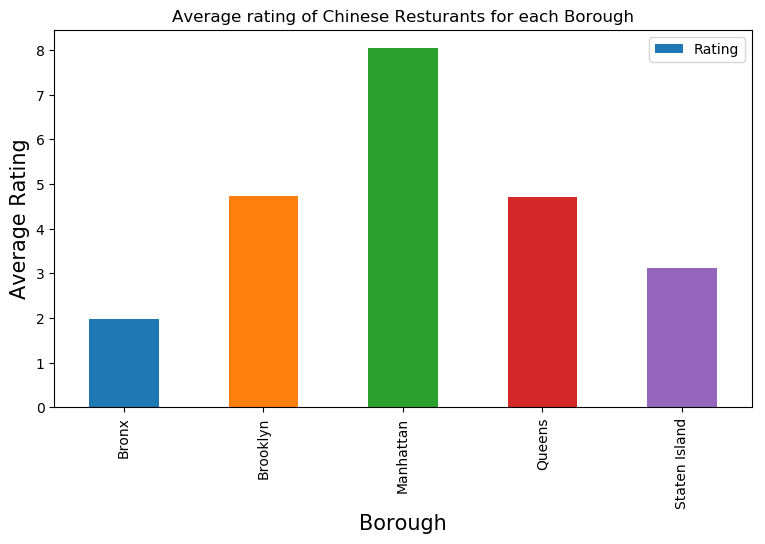

In [66]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Chinese Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
chinese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map.

In [67]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
28,Chelsea,9.2
54,East Village,9.0
83,Greenpoint,9.1
138,Noho,9.0
140,North Side,9.0


We will join this dataset to original new york data to get longitude and latitude.

In [68]:

ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Chelsea,40.744035,-74.003116,9.2
1,Staten Island,Chelsea,40.594726,-74.189560,9.2
2,Manhattan,East Village,40.727847,-73.982226,9.0
3,Brooklyn,Greenpoint,40.730201,-73.954241,9.1
4,Manhattan,Noho,40.723259,-73.988434,9.0
5,Brooklyn,North Side,40.714823,-73.958809,9.0


Finally, Let's show this data on a map.

In [72]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [73]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [75]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

## Conclusion:
### So now we can answer the questions asked above in the Questions section of the notebook.

#### From our anaysis the answers to the above questions are:

1. Chelsea(Manhattan), Chelsea(Staten Island), East Village (Manhattan) are some of the best neighborhoods for Chinese cuisine.
2. Manhattan have potential Chinese Resturant Market.
3. Bronx ranks last in average rating of Indian Resturants.
4. Manhattan is the best place to stay if you prefer Chinese Cuisine